In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd '/gdrive/My Drive/Colab Notebooks/gene_gsp_classification/'

/gdrive/My Drive/Colab Notebooks/gene_gsp_classification


In [3]:
import numpy as np
import pandas as pd
import os
import copy
import seaborn as sn
from IPython.display import Image
from datetime import datetime
from pynvml import *
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset
writer = SummaryWriter()
from sklearn.utils import class_weight

from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent

## Functions

In [4]:
def show_img(img, class_name):
    if torch.is_tensor(img):
        img=to_pil_image(img)
    print("class :",class_name)
    plt.imshow(img)

In [5]:
def get_class_names(y_data):
    y_class_names = []
    for i in range(len(y_data)):
        if(y_data[i]==0):
            y_class_names.append("inhibitor")
        elif (y_data[i]==1):
            y_class_names.append("forming")
    return y_class_names

In [6]:
def show_images(images, labels, preds,class_names):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}',fontsize = 40)
        plt.ylabel(f'{class_names[int(preds[i])]}', color=col,fontsize = 40)
    plt.tight_layout()
    plt.show()

In [7]:
def show_preds(model,loader,image_fun,loss_fn,class_names):
    model.eval() 
    print("test set evaluation")
    with torch.no_grad():
        accuracy = 0
        metric = 0
        pred = []
        train = []
        for test_step, (images, labels) in enumerate(tqdm(loader)):

          x_train = change_device(images)
          y_train = change_device(labels)
          y_pred = model(x_train)

          loss = loss_fn(y_pred,y_train)
          with torch.no_grad():
            
            for i in range(len(y_train)):
              if(int(torch.argmax(y_pred[i]).item())==int(y_train[i].item())):
                metric+=1 
              pred.append(torch.argmax(y_pred[i]).item())   
        accuracy = metric/len(loader.dataset)
        print(f' Accuracy: {accuracy:.4f}')
        image_fun(images[:4], y_train.cpu()[:4], pred[:4],class_names)
      
    return pred

In [8]:
def gene_tag(gene):
  gene_seq = []
  for i in range(len(gene)):
    if (gene[i]=="T"):
      gene_seq.append(0)
    elif (gene[i]=="G"):
      gene_seq.append(3)
    elif (gene[i]=="C"):
      gene_seq.append(1)
    elif (gene[i]=="A"):
      gene_seq.append(2)
  return gene_seq

In [9]:
ham = signal.get_window('hamming', 25)
def get_spectogram(gene_seq,path):
  f, t, Sxx = signal.spectrogram(np.array(gene_seq), fs=1, window = ham, mode = 'magnitude')
  #plt.pcolormesh(t, f, Sxx,vmin = np.min(Sxx), vmax = np.max(Sxx))
  plt.pcolormesh(t, f, Sxx)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel("Nucleotide Positions")
  plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
  plt.axis('tight')
  plt.axis('off')
  plt.savefig(path+'.png', dpi=300, frameon='false')

In [10]:
def change_device(input):
  if torch.cuda.is_available():
    return input.cuda()
  else:
    return input

In [11]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [12]:
def cudaalloc():
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'total    : {info.total}')
  print(f'free     : {info.free}')
  print(f'used     : {info.used}')

In [13]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [14]:
def loss_batch(loss_func, output, target, opt=None): 
     
    loss = loss_func(change_device(output), change_device(target))
    with torch.no_grad():
        metric = 0
        for i in range(len(target)):
            if(int(torch.argmax(output[i]).item())==int(target[i].item())):
                metric+=1      
                
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric

In [15]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl)
    total_data = len(dataset_dl.dataset)
    count=0;
    for xb, yb in tqdm(dataset_dl):
        xb=change_device(xb)
        yb=change_device(yb)
        
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        count+=1;
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(total_data)
    
    return loss, metric

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        writer.add_scalar("Loss/train", train_loss, epoch)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        writer.add_scalar("Loss/val", val_loss, epoch)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        print(train_metric)    
        print("train loss: %.6f, accuracy: %.2f" %(train_loss,train_metric))
        print("val loss: %.6f, accuracu: %.2f" %(val_loss,val_metric))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [18]:
def print_multi_confusion_matrix(actual_class, pred_class,target_names):
    df_array  = confusion_matrix(actual_class, pred_class)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Nucleosome')
    plt.ylabel('Predicted Nuclesome')
    sn.heatmap(df_cm, annot=True)
    sn.set(font_scale=1) 
    print(classification_report(actual_class, pred_class, target_names=target_names))

In [19]:
def print_activation_maps(model, img, labels, loss_func, y_pred, class_names):

  l = 1
  for r in range(0,4):
    xb_out = change_device(xb)
    output = model(xb_out[r].unsqueeze(0))
    target = np.argmax(output.cpu().detach().numpy())
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target] = 1
    output.backward(gradient = change_device(one_hot_output), retain_graph=True)
    gradients = model.get_activations_gradient()

    print(f' Actual class: {class_names[int(labels[r].cpu())]} predicted class : {class_names[int(torch.argmax(one_hot_output).item())]}')
    plt.figure(figsize=(20, 20))
    plt.subplot(6, 3, l , xticks=[], yticks=[])
    l = l+1
    

    image = np.asarray(img[r]).transpose(1,2,0)
    image = np.clip(image, 0., 1.)
    image_gray = rgb2gray(image)
    plt.imshow(image)

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(change_device(img)).cpu().detach()
    for i in range(activations.shape[1]):
      activations[:, i, :, :] *= pooled_gradients[i].cpu()
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.subplot(6, 3, l, xticks=[], yticks=[])
    plt.imshow(heatmap[r].squeeze())

    l = l+1
  
    heatmaps = cv2.resize(heatmap[r].numpy(), (image.shape[1], image.shape[0]))
    heatmaps = np.uint8(255 * heatmaps)
    superimposed_img = heatmaps*image_gray
  
    plt.subplot(6, 3, l, xticks=[], yticks=[])
    plt.imshow(superimposed_img)
    plt.show()
    l = l+1

## Data Loading

In [93]:
class specto_dataset(Dataset):
    def __init__(self, dataframe, transform=None):      

        self.SpecPath = dataframe['path'].values
        self.ClassName = dataframe['class'].values

        self.transform = transform
    
    def __len__(self):
        return len(self.SpecPath)
      
    def __getitem__(self, idx):
        path2img = self.SpecPath[idx]
        class_name = self.ClassName[idx]
        image = Image.open(path2img).convert('RGB')

        image= np.array(image)    

        if self.transform:
            image = self.transform(image)       
          #he to_tensor function normalizes the values by diving them to 255. As such, we scaled back the mask values to the range of [0, 1] by multiplying it by 255.             
        return image, class_name

In [94]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

In [95]:
#melanogaster
#sapiens
data1 = pd.read_csv('nucleosome/final_melanogaster_sft.csv')
data2 = pd.read_csv('nucleosome/final_sapiens_sft.csv')
data_new = pd.concat([data1,data2])
data_new.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)
data_new = data_new.reset_index(drop=True)
class_name = []
for i in range(len(data_new)):
  if(data_new['label'][i]=='Nucleosome_Forming'):
    class_name.append(1)
  elif(data_new['label'][i]=='Nucleosome_Inhibiting'):
    class_name.append(0)
data_new['class'] = class_name
  


In [96]:
test_data = pd.read_csv('nucleosome/final_C_elegans_sft.csv')
class_name = []
for i in range(len(test_data)):
  if(test_data['label'][i]=='Nucleosome_Forming'):
    class_name.append(1)
  elif(test_data['label'][i]=='Nucleosome_Inhibiting'):
    class_name.append(0)
test_data['class'] = class_name
test_ds =specto_dataset(test_data,transform)
batch_size = 32
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [97]:
spec_ds1=specto_dataset(data_new,transform)
spec_ds2=specto_dataset(data_new,transform)
print(len(spec_ds1))
print(len(spec_ds1))

10323
10323


In [98]:
img,class_name= spec_ds1[2]
print(img.shape, img.type(),torch.max(img),class_name)

torch.Size([3, 224, 224]) torch.FloatTensor tensor(1.) 1


In [99]:
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(spec_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

8258
----------
2065


In [100]:
train_ds=Subset(spec_ds1,train_index)
print(len(train_ds))

val_ds=Subset(spec_ds2,val_index)
print(len(val_ds))

8258
2065


class : 0


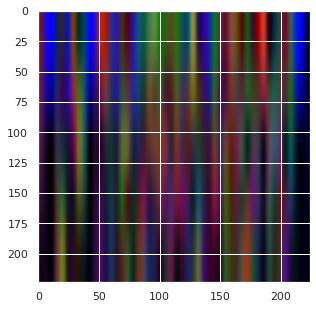

In [101]:
plt.figure(figsize=(5,5))
for img,class_name in train_ds:
    show_img(img, class_name)
    break

class : 0


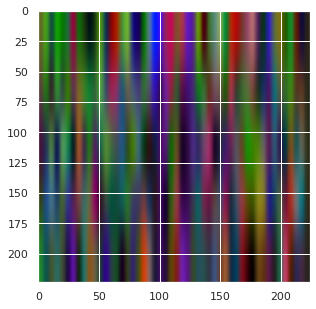

In [102]:
plt.figure(figsize=(5,5))
for img,class_name in val_ds:
    show_img(img, class_name) 
    break

In [103]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [104]:
for img_b, class_name in test_dl:
    print(img_b.shape,class_name)
    break

torch.Size([32, 3, 224, 224]) tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0])


In [105]:
for img_b, class_name in train_dl:
    images,labels = img_b, class_name
    print(img_b.shape,class_name)
    break

torch.Size([32, 3, 224, 224]) tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0])


In [106]:
for img_b, class_name in val_dl:
    print(img_b.shape,class_name)
    break

torch.Size([32, 3, 224, 224]) tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1])


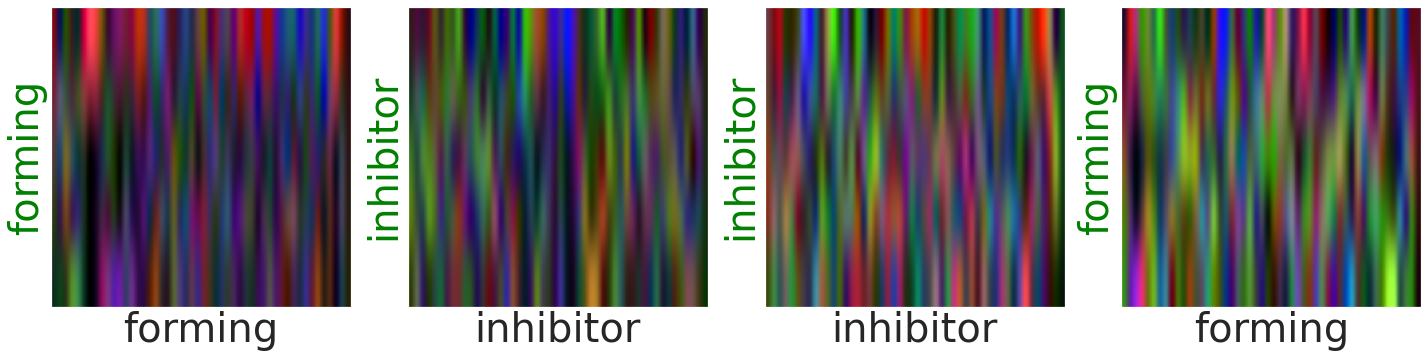

In [107]:
class_names = {}
class_names[1] = 'forming'
class_names[0] = 'inhibitor'
show_images(images[:4],labels[:4],labels[:4],class_names)

## Model Implementation

In [108]:
densenet121 = torchvision.models.densenet121(pretrained=True)

In [109]:
class DenseNet(nn.Module):
    def __init__(self, model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.averagepool = nn.AdaptiveAvgPool2d(1)
        
        # get the classifier of the vgg19
        self.classifier = torch.nn.Linear(in_features=1024, out_features=2)
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        if x.requires_grad:
          h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [110]:
model = change_device(DenseNet(densenet121))

In [111]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 7,980,906 trainable parameters and total memory usage is 91.33422088623047 mb


In [112]:
class_weights = class_weight.compute_class_weight('balanced',classes = [0,1],y = data_new['class'].values)
print(class_weights)

[1.00223301 0.99777692]


In [113]:
opt = optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.1, patience=10,verbose=1)
loss_func = torch.nn.CrossEntropyLoss(weight = change_device(torch.tensor(class_weights)).float())
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [114]:
cudaalloc()

total    : 17071734784
free     : 10554703872
used     : 6517030912


In [115]:
root = 'nucleosome/'

In [116]:
path2models= root + "models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+ "C_elegans_sft" + datetime.now().strftime('%M:%S_') + "weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Copied best model weights!
0.7364979413901671
train loss: 0.540022, accuracy: 0.74
val loss: 0.537329, accuracu: 0.75
----------
Epoch 1/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.8063695810123517
train loss: 0.433535, accuracy: 0.81
val loss: 0.581536, accuracu: 0.71
----------
Epoch 2/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Copied best model weights!
0.8486316299346088
train loss: 0.367381, accuracy: 0.85
val loss: 0.503327, accuracu: 0.76
----------
Epoch 3/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.8632840881569387
train loss: 0.326611, accuracy: 0.86
val loss: 0.534144, accuracu: 0.77
----------
Epoch 4/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.8946476144344878
train loss: 0.256173, accuracy: 0.89
val loss: 0.582615, accuracu: 0.79
----------
Epoch 5/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.9260111407120368
train loss: 0.192141, accuracy: 0.93
val loss: 0.769495, accuracu: 0.74
----------
Epoch 6/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.9298861709857108
train loss: 0.174219, accuracy: 0.93
val loss: 0.740100, accuracu: 0.74
----------
Epoch 7/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.9389682731896343
train loss: 0.164191, accuracy: 0.94
val loss: 0.681054, accuracu: 0.76
----------
Epoch 8/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.9421167352869945
train loss: 0.150116, accuracy: 0.94
val loss: 0.720082, accuracu: 0.77
----------
Epoch 9/9, current lr=0.0003


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.9642770646645676
train loss: 0.097137, accuracy: 0.96
val loss: 0.861331, accuracu: 0.74
----------


In [117]:
from bokeh.plotting import figure, show

# prepare some data
x = np.arange(0,len(loss_hist['train'])) 
y1 = loss_hist['train']
y2 = loss_hist['val']

# create a new plot with a title and axis labels
p = figure(title="Loss function of train and val", x_axis_label="x", y_axis_label="y",plot_width=1000, plot_height=400,align="center")
p.title.align = "center"
# add a line renderer with legend and line thickness
p.line(x, y1, legend_label="Train", line_width=2)
p.line(x, y2, legend_label="val", line_color="red", line_width=2)
output_notebook()
# show the results
show(p)

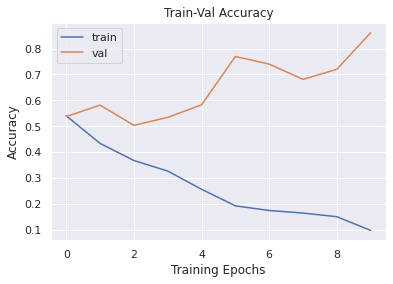

In [118]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
x = np.arange(0,len(loss_hist['train'])) 
y1 = loss_hist['train']
y2 = loss_hist['val']
plt.plot(x,y1,label="train")
plt.plot(x,y2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [119]:
from bokeh.plotting import figure, show

# prepare some data
x = np.arange(0,len(metric_hist['train'])) 
y1 = metric_hist['train']
y2 = metric_hist['val']

# create a new plot with a title and axis labels
p = figure(title="Accuracy of train and val", x_axis_label="x", y_axis_label="y",plot_width=1000, plot_height=500,align="center")
p.title.align = "center"
# add a line renderer with legend and line thickness
p.line(x, y1, legend_label="Train", line_width=2)
p.line(x, y2, legend_label="val", line_color="red", line_width=2)
output_notebook()
# show the results
show(p)

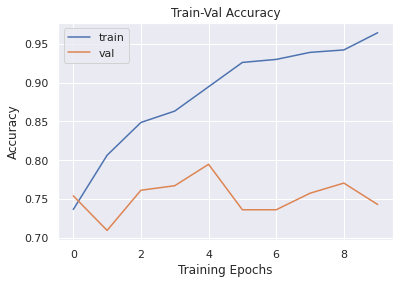

In [120]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
x = np.arange(0,len(metric_hist['train'])) 
y1 = metric_hist['train']
y2 = metric_hist['val']
plt.plot(x,y1,label="train")
plt.plot(x,y2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

test set evaluation


  0%|          | 0/162 [00:00<?, ?it/s]

 Accuracy: 0.5376


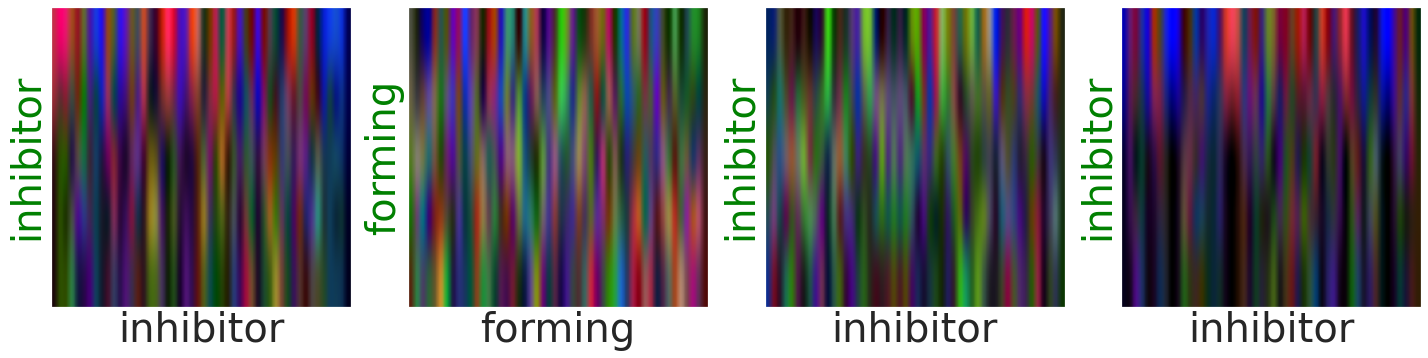

In [121]:
pred = show_preds(model,test_dl,show_images,loss_func,class_names)

In [122]:
#megalanomase accuracy = 

In [123]:
model.eval() 
softmax = nn.Softmax(dim=0)
loss_func = torch.nn.CrossEntropyLoss(weight = change_device(torch.tensor(class_weights)).float())
with torch.no_grad():
  accuracy = 0
  metric = 0
  pred = []
  y_test_data = []
  pred_prob = []
  for test_step, (images, labels) in enumerate(tqdm(test_dl)):
    x_test = change_device(images)
    y_test = change_device(labels)
    y_pred = model(x_test)
    
    loss = loss_func(y_pred,y_test)
    with torch.no_grad():
      
      for i in range(len(y_test)):
        if(int(torch.argmax(y_pred[i]).item())==int(y_test[i].item())):
          metric+=1 
        y_test_data.append(int(y_test[i].item()))
        pred.append(int(torch.argmax(y_pred[i]).item()))  
        pred_prob.append(np.array(softmax(y_pred[i]).cpu())) 
accuracy = metric/len(test_dl.dataset)
print(f' Accuracy: {accuracy:.4f}')

  0%|          | 0/162 [00:00<?, ?it/s]

 Accuracy: 0.5376


              precision    recall  f1-score   support

   inhibitor       0.53      0.64      0.58      2608
     forming       0.54      0.44      0.48      2567

    accuracy                           0.54      5175
   macro avg       0.54      0.54      0.53      5175
weighted avg       0.54      0.54      0.53      5175



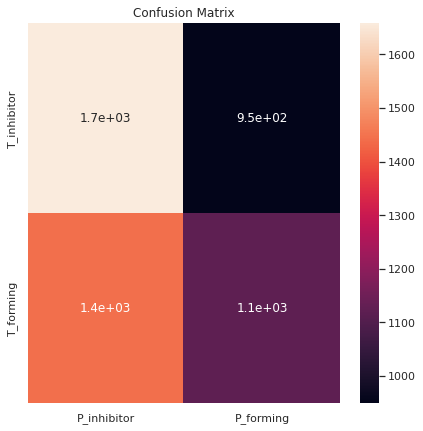

In [124]:
actual_class = y_test_data
pred_class = pred
classnames = ['inhibitor', 'forming']
print_multi_confusion_matrix(actual_class,pred_class,target_names=classnames)
y_test_class_names = get_class_names(actual_class)
plt.show()

In [126]:


def get_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    return fpr,tpr,threshold

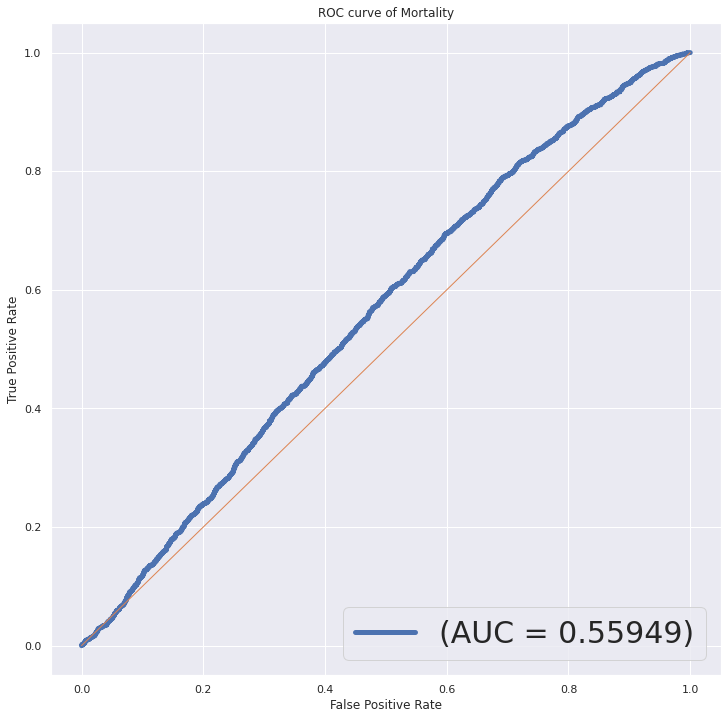

In [127]:
class_names=["Alive","Dead"]
y_test_class_names = get_class_names(actual_class)
y_test_class = label_binarize(np.array(y_test_class_names),classes=classnames)
pred_prob = np.array(pred_prob)
y_test_class = np.array(y_test_class)
fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
fig1 = plt.figure(figsize=[12,12])
plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Mortality')
plt.legend(loc="lower right",prop={'size': 30})
plt.show()



In [128]:

stop = 10
count= 0
for xb, yb in test_dl:
    if(count==stop):
        break
    count+=1
xb_out = change_device(xb)
model.eval()
output = model(xb_out[0].unsqueeze(0))
target = np.argmax(output.cpu().detach().numpy())
one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target] = 1
print(output , one_hot_output)


tensor([[ 0.1298, -0.3265]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[1., 0.]])


 Actual class: forming predicted class : inhibitor


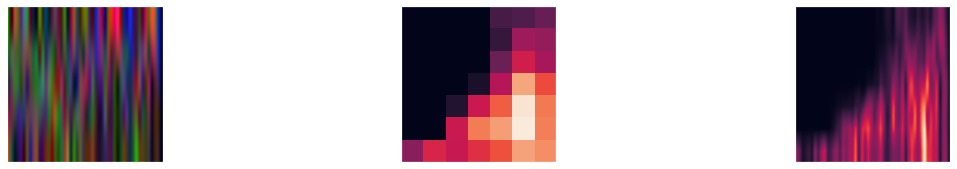

 Actual class: inhibitor predicted class : inhibitor


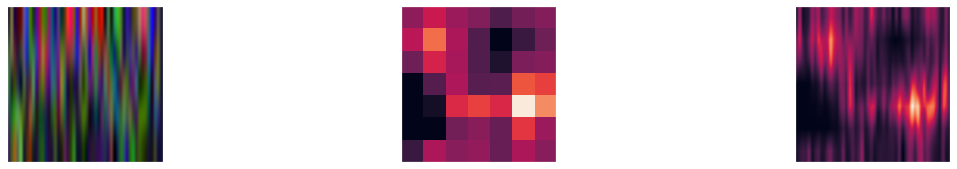

 Actual class: inhibitor predicted class : inhibitor


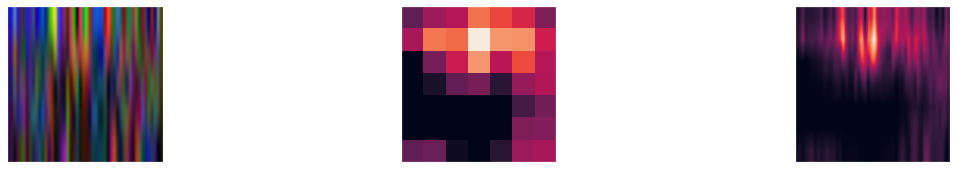

 Actual class: inhibitor predicted class : forming


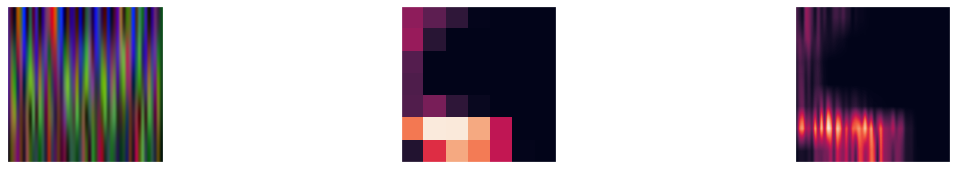

In [129]:
import cv2
print_activation_maps(model, xb, yb, loss_func, output, classnames)